In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

# Description
This notebook utilizes feature engineering and a random forest regressor to predict NCAA March Madness 2023 Tournament game outcomes

I divided into the following sections:

- 1) Preprocessing
- 2) Feature engineering
- 3) Hyperparameter selection and modeling fitting
- 4) Results

## 1) Preprocessing
Reading files from the ./Data folder into dataframes for feature engineering.

Dataframe metadata:
- tourney_games: historical results (winning score/losing score) for all previous tournament games
- season_games: historical results (winning score/losing score) for all previous regular season games
- tourney_games_detail: historical in-depth game statistics (field goal pct., 3 point pct., etc.) for all previous tournament games
- season_games_detail: historical in-depth game statistics (field goal pct., 3 point pct., etc.) for all previous regular season games
- seeds: historical data aligning teams to their respective tournament seed
- massey: historical data containing weekly rankings for all eligible tournament teams
- test_games: template for final output file with predictions for every possible game
- teams: maps team names to team ID's

In [2]:
warnings.filterwarnings("ignore")

cd = "./Data/"

tourney_games = pd.read_csv(cd + "/MNCAATourneyCompactResults.csv")
season_games = pd.read_csv(cd + "/MRegularSeasonCompactResults.csv")
tourney_games_detailed = pd.read_csv(cd + "/MNCAATourneyDetailedResults.csv")
season_games_detailed = pd.read_csv(cd + "/MRegularSeasonDetailedResults.csv")
seeds = pd.read_csv(cd + "/MNCAATourneySeeds.csv")
massey = pd.read_csv(cd + "/MMasseyOrdinals_thru_Season2023_Day128.csv")
test_games = pd.read_csv(cd + "/SampleSubmission2023.csv")
teams = pd.read_csv(cd + "/MTeams.csv")

## 2) Feature Engineering
Because many features I will use did not start recording data until the early 2000's, and because NCAA basketball has rapidly evolved over the last 20 years, I decided to slice the dataframes to eliminate seasons before 2003. 

In [3]:
tourney_games = tourney_games[tourney_games['Season'] > 1998]
season_games = season_games[season_games['Season'] > 2002]
tourney_games_detailed = tourney_games_detailed[tourney_games_detailed['Season'] > 2002]
season_games_detailed = season_games_detailed[season_games_detailed['Season'] > 2002]
seeds = seeds[seeds['Season'] > 2002]

In [4]:
tourney_games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
882,1999,136,1116,94,1373,80,N,0
883,1999,136,1120,80,1457,41,N,0
884,1999,136,1163,91,1427,66,N,0
885,1999,136,1166,62,1257,58,N,0
886,1999,136,1178,56,1417,53,N,0


In [5]:
season_games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
74048,2003,10,1104,68,1328,62,N,0
74049,2003,10,1272,70,1393,63,N,0
74050,2003,11,1266,73,1437,61,N,0
74051,2003,11,1296,56,1457,50,N,0
74052,2003,11,1400,77,1208,71,N,0


In [6]:
test_games.head()

,ID,Pred
0,2023_1101_1102,0.5
1,2023_1101_1103,0.5
2,2023_1101_1104,0.5
3,2023_1101_1105,0.5
4,2023_1101_1106,0.5


We can see that test_games['ID'] is arranged year_team1_team2. Let's create columns to match season_games, tourney_games, and test_games.

In [7]:
def test_features(df):
    df[['Season', 'Team1', 'Team2']] = df.iloc[:,0].str.split(pat='_', expand=True)
    df['DayNum'] = 134
    cols = ['Season', 'Team1', 'Team2', 'DayNum']
    return df[cols]
test_games = test_features(test_games)

Next, I want to convert team ID's to integer values

In [8]:
test_games['Team1'] = pd.to_numeric(test_games['Team1'])
test_games['Team2'] = pd.to_numeric(test_games['Team2'])
test_games.dtypes

Season    object
Team1      int64
Team2      int64
DayNum     int64
dtype: object

I only want to include teams currently in the tournament in my test_games dataframe. Because there are 68 teams in the tournament and 2 teams per game, we should expect 68 choose 2 observations (2278).

In [9]:
teams_list = seeds[seeds['Season'] == 2023]['TeamID'].tolist()
test_games1 = test_games[test_games['Team1'].isin(teams_list)]
test_games = test_games1[test_games['Team2'].isin(teams_list)]
test_games.shape

(2278, 4)

season_games and tourney_games contain the same column metadata. Let's create some features to align our data with that of the test_games dataframe and make more actionable features for modeling:

- Team1 and Team2 columns - Create team columns while keeping in mind that Team1 must always be less than Team2
- Score_differential - Create column subtracting losing score from winning score

In [10]:
def create_features(df):
    (df['Team1'], df['Team2']) = np.where(df['WTeamID'] < df['LTeamID'], (df['WTeamID'], df['LTeamID']), (df['LTeamID'], df['WTeamID']))
    df['Score_differential'] = np.where(df['WTeamID'] == df['Team1'], df.WScore - df.LScore, df.LScore - df.WScore) # Subtract Team2 score from Team1 score to get differential
    cols = ['Season', 'Team1', 'Team2', 'DayNum', 'Score_differential']
    return df[cols]
tourney_games = create_features(tourney_games)
season_games = create_features(season_games)

In [11]:
tourney_games.head()

,Season,Team1,Team2,DayNum,Score_differential
882,1999,1116,1373,136,14
883,1999,1120,1457,136,39
884,1999,1163,1427,136,25
885,1999,1166,1257,136,4
886,1999,1178,1417,136,3


In [12]:
games = tourney_games # Placeholder for later use
tourney_games = tourney_games[tourney_games['Season'] > 2002]

We will create 4 more features to train the model on as follows:
- Seed_difference - Difference in seeds between Team1 and Team2.
- Ranking_difference - Difference in ranking between Team1 and Team2 using Massey Ordinals.
- Tourney_games_difference - Difference in number of playoff games played prior to this season. This indicates previous tournament success by the two teams.
- Previous_score_difference - Difference in the scores between teams with previous matchups. 

In [13]:
seeds.head()

,Season,Seed,TeamID
1154,2003,W01,1328
1155,2003,W02,1448
1156,2003,W03,1393
1157,2003,W04,1257
1158,2003,W05,1280


In [14]:
def seed_int(seed):
    seed = int(seed[1:3]) # Convert the seed into an int
    return seed
seeds['Seed'] = seeds.Seed.apply(seed_int)
seeds = seeds.set_index(['Season', 'TeamID'])
seeds = seeds['Seed'].to_dict()

We mapped seeds to each tournament year and team ID to create the feature in a follow-on method

In [15]:
def seed_feature(df):
    df = df.astype('int64')
    df['Seed_diff'] = df.apply(lambda row: (seeds[(row.Season, row.Team1)] - seeds[(row.Season, row.Team2)]), axis=1) # Subtract team seeds to form new feature similar to format of Score_differential 
    return df
tourney_games = seed_feature(tourney_games)
test_games = seed_feature(test_games)

We expect seed difference to be negatively correlated to score differential because seeds with lower values (1,2,3, etc.) are expected to beat teams with higher seeds

In [16]:
tourney_games.head()

,Season,Team1,Team2,DayNum,Score_differential,Seed_diff
1136,2003,1411,1421,134,-8,0
1137,2003,1112,1436,136,29,-15
1138,2003,1113,1272,136,13,3
1139,2003,1141,1166,136,6,5
1140,2003,1143,1301,136,2,-1


In [17]:
massey.tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
4922507,2023,128,WOL,1473,332
4922508,2023,128,WOL,1474,166
4922509,2023,128,WOL,1475,260
4922510,2023,128,WOL,1476,301
4922511,2023,128,WOL,1477,303


Massey Ordinals are ranked based on the Season, RankingDayNum, and TeamID. Therefore, if we group the rankings by those three variables and determine the middle value across each system, we get an accurate picture of the percieved performance of each team at a particular time.

In [18]:
massey["SystemName"].value_counts()

SystemName
SAG    130008
MOR    129018
POM    126527
DOK    113231
WLK    103919
        ...  
CRW       351
PMC       351
HRN       351
BP5       345
PH        326
Name: count, Length: 190, dtype: int64

In [19]:
massey.drop('SystemName', axis=1, inplace=True)

In [20]:
massey = massey.groupby(['TeamID','Season', 'RankingDayNum']).median().astype('int64')

In [21]:
massey.head()

OrdinalRank
TeamID Season RankingDayNum             
1101   2014   9                      347
              16                     349
              23                     341
              30                     341
              37                     337

In [22]:
massey_dict = massey['OrdinalRank'].to_dict()

We can now subtract rankings for teams playing one another on a particular day. If the day of the ranking does not match the day of the matchup, we find the most recent previous ranking for each team.

In [23]:
def massey_ranking_diff(team1, team2, season, daynum):
    try: 
        Ranking1 = massey_dict[(team1, season, daynum)] # In the case a matchup places a team in the Team1 position
    except:
        try:
            RankingDays1 = massey.loc[team1, season].index
            DayNum1 = RankingDays1[RankingDays1 < daynum][-1] # Finds closest day less than day of game
            Ranking1 = massey_dict[(team1, season, DayNum1)] # Placeholds rank of team at time of game
        except:
            return np.nan
    try:
        Ranking2 = massey_dict[(team2, season, daynum)] # In the case a matchup places a team in the Team2 position
    except:
        try:
            RankingDays2 = massey.loc[team2,season].index
            DayNum2 = RankingDays2[RankingDays2 < daynum][-1]
            Ranking2 = massey_dict[(team2, season, DayNum2)]
        except:
            return np.nan
    return Ranking1 - Ranking2

In [24]:
def ranking_diff_feature(df):
    df['Ranking_diff'] = df.apply(lambda row: massey_ranking_diff(row.Team1, row.Team2, row.Season, row.DayNum), axis=1) # Creates feature using above method
    return df
test_games = ranking_diff_feature(test_games)
tourney_games = ranking_diff_feature(tourney_games)
season_games = ranking_diff_feature(season_games)

In [25]:
season_games[season_games['Season']>2002]['Ranking_diff'].isna().sum()

5432

Utilizing the games dataframe created at the beginning of the notebook, we will track recent tournament success for each team by adding the number of tournament game appearances each team has had within the last 4 years of tournaments prior to the current game. 

In [26]:
games = games.set_index('Season').groupby('Season')
games.sample(1)

,Team1,Team2,DayNum,Score_differential
Season,,,,
1999,1116,1234,138,-10
2000,1211,1385,138,6
2001,1209,1458,136,1
2002,1390,1443,136,16
2003,1451,1458,136,-7
2004,1181,1228,144,10
2005,1235,1278,137,11
2006,1137,1272,139,-16
2007,1338,1460,136,21


Starting with year 1999, we will use a counter to add tournament games to each team's ID through the 2022 season. In order to only record recent tournament success, we will dump games from the counter that occured over 4 years prior to the current game. Because COVID-19 cancelled 2020's tournament, I had to develop a workaround to dump games appropriately

In [27]:
tourney_games_count = {1999: {}}
count_2021 = {}
for grp in games:
    season = (grp[0]+1)
    df = pd.concat([grp[1].Team1.value_counts(), grp[1].Team2.value_counts()], axis=1).fillna(0)
    df.columns = ['Team1', 'Team2']
    df['season'] = season
    df['Games_played'] = df.Team1 + df.Team2
    current_count = df.Games_played.to_dict()
    if season < 2003:
        total_count = Counter(tourney_games_count[season-1]) + Counter(current_count)
        tourney_games_count[season] = total_count
    elif season < 2021:
        total_count = Counter(tourney_games_count[season-1]) + Counter(current_count) - Counter(tourney_games_count[season-4])
        tourney_games_count[season] = total_count
    elif season == 2021:
        total_count = Counter(tourney_games_count[season-2]) + Counter(current_count) - Counter(tourney_games_count[season-5])
        tourney_games_count[season] = total_count
        count_2021 = current_count
    else:
        total_count = Counter(tourney_games_count[season-3]) + Counter(count_2021) + Counter(current_count) - Counter(tourney_games_count[season-5])
        tourney_games_count[season] = total_count

Because we are only looking at games starting in 2003, we can delete results for years 1999-2002.

In [28]:
del tourney_games_count[1999]
del tourney_games_count[2000]
del tourney_games_count[2001]
del tourney_games_count[2002]

Now we can utilize the dictionary created above to build a new feature in our dataframes. 

In [29]:
def games_played_diff(team1, team2, season, test=False):
    if test:
        team1_games_played = tourney_games_count[2022].get(team1, 0) # References the counter year 2022 in our dictionary, assigns 0 if the team is not present in the counter
        team2_games_played = tourney_games_count[2022].get(team2, 0)
    else:
        if season == 2021:
            team1_games_played = tourney_games_count[2020].get(team1, 0) # COVID-19 workaround
            team2_games_played = tourney_games_count[2020].get(team2, 0)
        else:
            team1_games_played = tourney_games_count[season].get(team1, 0)
            team2_games_played = tourney_games_count[season].get(team2, 0)
    return (team1_games_played - team2_games_played)

def games_played_feature(df, test=False):
    df["Tourney_games_diff"] = df.apply(lambda row: games_played_diff(row.Team1, row.Team2, row.Season, test), axis=1) # Subtracts tournament experience between two teams in a matchup
    df["Tourney"] = 1 # Feature created to tell the model whether or not the game is a tournament
    return df
tourney_games = games_played_feature(tourney_games)
test_games = games_played_feature(test_games, test=True)
season_games = games_played_feature(season_games)
season_games["Tourney"] = 0 # Feature created to tell the model whether or not the game is a tournament game

Now we want to calculate the average historical score between 2 teams playing each other. We will use weighted averages to reduce the calculation density.

In [30]:
tourney_games.tail()

,Season,Team1,Team2,DayNum,Score_differential,Seed_diff,Ranking_diff,Tourney_games_diff,Tourney
2379,2022,1242,1274,146,26,-9,-50,-1.0,1
2380,2022,1314,1389,146,20,-7,-100,1.0,1
2381,2022,1242,1437,152,16,-1,-5,-11.0,1
2382,2022,1181,1314,152,-4,-6,-18,-1.0,1
2383,2022,1242,1314,154,3,-7,-27,-1.0,1


In [31]:
all_games = pd.concat([tourney_games, season_games]).copy().sort_values(['Season', 'DayNum']) # Combines tournament and season games into one dataframe
all_games.tail()

,Season,Team1,Team2,DayNum,Score_differential,Seed_diff,Ranking_diff,Tourney_games_diff,Tourney
181677,2023,1104,1401,132,19,NaN,-21.0,-2.0,0
181678,2023,1222,1272,132,-10,NaN,-27.0,7.0,0
181679,2023,1343,1463,132,9,NaN,41.0,-2.0,0
181680,2023,1336,1345,132,-2,NaN,46.0,-10.0,0
181681,2023,1173,1433,132,-12,NaN,18.0,0.0,0


In [32]:
hash_scores = {}
b = 0.8

def scores(row):
    if (row.Team1, row.Team2) in hash_scores:
        prev_avg_score = hash_scores[(row.Team1, row.Team2)]
        current_score = (b * prev_avg_score) + ((1-b) * row.Score_differential) # Updates score differential using a weighted average
    else:
        prev_avg_score = 0
        current_score = row.Score_differential
    hash_scores[(row.Team1, row.Team2)] = current_score # Assigns current score differential to hashmap
    return prev_avg_score
all_games['Avg_score_diff'] = all_games.apply(lambda row: scores(row), axis=1) # Creates feature to track previous score differential
all_games = all_games.set_index(['Team1', 'Team2', 'Season', 'DayNum'])
all_games.sample(10)

,,,,Score_differential,Seed_diff,Ranking_diff,Tourney_games_diff,Tourney,Avg_score_diff
Team1,Team2,Season,DayNum,,,,,,
1181,1268,2011,130,16,NaN,-66.0,7.0,0,9.891472
1220,1318,2011,96,3,NaN,-92.0,0.0,0,-1.549603
1142,1413,2009,82,2,NaN,83.0,0.0,0,-0.787354
1326,1393,2008,16,14,NaN,1.0,1.0,0,0.000000
1155,1314,2008,62,-2,NaN,17.0,0.0,0,-13.315712
1126,1411,2004,42,-12,NaN,-79.0,-1.0,0,0.000000
1212,1238,2010,128,8,NaN,110.0,0.0,0,-6.408684
1291,1384,2007,101,15,NaN,-62.0,0.0,0,3.044188
1138,1141,2019,130,4,NaN,-107.0,4.0,0,9.012308


The function below reassigns the feature back down to separate tournament and regular season dataframes.

In [33]:
all_games = all_games['Avg_score_diff'].to_dict()

def score_difference(games, test=False):
    if test:
        games['Avg_score_diff'] = games.apply(lambda row: hash_scores.get((row.Team1, row.Team2), 0), axis=1)
    else:
        games['Avg_score_diff'] = games.apply(lambda row: all_games[(row.Team1, row.Team2, row.Season, row.DayNum)], axis=1)
    return games
tourney_games = score_difference(tourney_games)
season_games = score_difference(season_games)
test_games = score_difference(test_games, test=True)

In [34]:
test_games['Team1'] = test_games['Team1'].astype('int64')
test_games['Team2'] = test_games['Team2'].astype('int64')

In [35]:
test_games.sample(10)

,Season,Team1,Team2,DayNum,Seed_diff,Ranking_diff,Tourney_games_diff,Tourney,Avg_score_diff
56256,2023,1336,1343,134,-5,-70,0.0,1,18.000000
1313,2023,1104,1345,134,0,-3,0.0,1,-6.360000
39775,2023,1242,1425,134,-9,-32,-6.0,1,0.521600
27272,2023,1192,1266,134,14,287,0.0,1,0.000000
46136,2023,1272,1411,134,-8,-280,-4.0,1,0.000000
59413,2023,1361,1401,134,-2,-8,-3.0,1,0.000000
17295,2023,1158,1268,134,4,23,0.0,1,-1.000000
18813,2023,1163,1246,134,-2,-16,1.0,1,4.867200
4073,2023,1113,1266,134,9,49,0.0,1,-0.840000
34995,2023,1222,1395,134,-5,-26,6.0,1,2.892441


Before feature assessment and selection, let's create some detailed features using team shooting performance (FG% and 3FG%)

In [36]:
def create_detailed_features(df):
    (df['Team1'], df['Team2']) = np.where(df['WTeamID'] < df['LTeamID'], (df['WTeamID'], df['LTeamID']), (df['LTeamID'], df['WTeamID']))
    df['Score_differential'] = np.where(df['WTeamID'] == df['Team1'], df.WScore - df.LScore, df.LScore - df.WScore)
    df['Team1PCT3'] = np.where(df['WTeamID'] == df['Team1'], df.WFGM3 / df.WFGA3, df.LFGM3 / df.LFGA3)
    df['Team2PCT3'] = np.where(df['WTeamID'] == df['Team2'], df.WFGM3 / df.WFGA3, df.LFGM3 / df.LFGA3)
    df['Team1PCT'] = np.where(df['WTeamID'] == df['Team1'], df.WFGM / df.WFGA, df.LFGM / df.LFGA)
    df['Team2PCT'] = np.where(df['WTeamID'] == df['Team2'], df.WFGM / df.WFGA, df.LFGM / df.LFGA)
    cols = ['Season', 'Team1', 'Team2', 'DayNum', 'Team1PCT3', 'Team2PCT3', 'Team1PCT', 'Team2PCT']
    return df[cols]
tourney_games_detailed = create_detailed_features(tourney_games_detailed)
season_games_detailed = create_detailed_features(season_games_detailed)

In [37]:
all_games_detailed = pd.concat([tourney_games_detailed, season_games_detailed]).copy().sort_values(['Season', 'DayNum'])
all_games_team1 = all_games_detailed[['Season', 'Team1', 'DayNum', 'Team1PCT3', 'Team1PCT']]
all_games_team2 = all_games_detailed[['Season', 'Team2', 'DayNum', 'Team2PCT3', 'Team2PCT']]
all_games_team1.rename(columns={'Team1':'TeamID','Team1PCT3':'PCT3','Team1PCT':'PCT'}, inplace=True)
all_games_team2.rename(columns={'Team2':'TeamID', 'Team2PCT3':'PCT3','Team2PCT':'PCT'}, inplace=True)
all_games_team1.shape

(108882, 5)

In [38]:
all_games_detailed = pd.concat([all_games_team1,all_games_team2]).copy().sort_values(['Season','TeamID','DayNum'])
all_games_detailed.shape

(217764, 5)

Similar to how we used weighted averages to update historical matchup performance, we will also update shooting percentage using weighted average. 

In [39]:
b = 0.8
hash_percent = {}
hash_three_percent = {}
def percentage(row):
    if row.TeamID in hash_percent:
        prev_avg_percent = hash_percent[row.TeamID]
        current_percent = (b * prev_avg_percent) + ((1-b) * row.PCT)
    else: 
        prev_avg_percent = 0
        current_percent = row.PCT
    hash_percent[row.TeamID] = current_percent
    return prev_avg_percent

all_games_detailed['Avg_PCT'] = all_games_detailed.apply(lambda row: percentage(row), axis=1)

def percentage_three(row):
    if (row.Season, row.TeamID) in hash_three_percent:
        prev_avg_percent = hash_three_percent[(row.Season, row.TeamID)]
        current_percent = (b * prev_avg_percent) + ((1-b) * row.PCT3)
    else: 
        prev_avg_percent = 0
        current_percent = row.PCT3
    hash_three_percent[(row.Season, row.TeamID)] = current_percent
    return prev_avg_percent

all_games_detailed['Avg_PCT3'] = all_games_detailed.apply(lambda row: percentage_three(row), axis=1)

all_games_detailed = all_games_detailed.drop(['PCT3','PCT'], axis=1)

In [40]:
percent_three_dict = all_games_detailed.set_index(['Season','TeamID','DayNum'])['Avg_PCT3'].to_dict()
percent_dict = all_games_detailed.set_index(['Season','TeamID','DayNum'])['Avg_PCT'].to_dict()

Lastly, we will subtract field goal and 3 point shooting percentages amongst matched teams to create our final features: Percent_FG_diff and Percent_FG3_diff. 

In [41]:
def percent_diff(team1, team2, season, daynum):
    Percent1 = percent_dict[(season, team1, daynum)]
    Percent2 = percent_dict[(season, team2, daynum)]
    return Percent1 - Percent2

def percent_three_diff(team1, team2, season, daynum):
    Percent1 = percent_three_dict[(season, team1, daynum)]
    Percent2 = percent_three_dict[(season, team2, daynum)]
    return Percent1 - Percent2

def percent_diff_feature(df, test=False):
    if test==True:
        df['Percent_FG_diff'] = df.apply(lambda row: hash_percent.get(row.Team1, 0) - hash_percent.get(row.Team2, 0), axis=1)
        df['Percent_FG3_diff'] = df.apply(lambda row: hash_three_percent.get((row.Season, row.Team1), 0) - hash_three_percent.get((row.Season, row.Team2), 0), axis=1)
    else:
        df['Percent_FG_diff'] = df.apply(lambda row: percent_diff(row.Team1, row.Team2, row.Season, row.DayNum), axis=1)
        df['Percent_FG3_diff'] = df.apply(lambda row: percent_three_diff(row.Team1, row.Team2, row.Season, row.DayNum), axis=1)
    return df
test_games = percent_diff_feature(test_games, test=True)
tourney_games = percent_diff_feature(tourney_games)
season_games = percent_diff_feature(season_games)

In [42]:
tourney_games.tail()

,Season,Team1,Team2,DayNum,Score_differential,Seed_diff,Ranking_diff,Tourney_games_diff,Tourney,Avg_score_diff,Percent_FG_diff,Percent_FG3_diff
2379,2022,1242,1274,146,26,-9,-50,-1.0,1,0.000000,-0.043782,0.029468
2380,2022,1314,1389,146,20,-7,-100,1.0,1,0.000000,0.003025,-0.010933
2381,2022,1242,1437,152,16,-1,-5,-11.0,1,-1.257638,0.055246,-0.004150
2382,2022,1181,1314,152,-4,-6,-18,-1.0,1,-1.571146,0.088523,0.046955
2383,2022,1242,1314,154,3,-7,-27,-1.0,1,1.152000,0.036791,0.035076


Now that we have our potential features developed, I created a correlation matrix to visualize how features correlated to one another and to our target variable (Score_differential)

<Axes: >

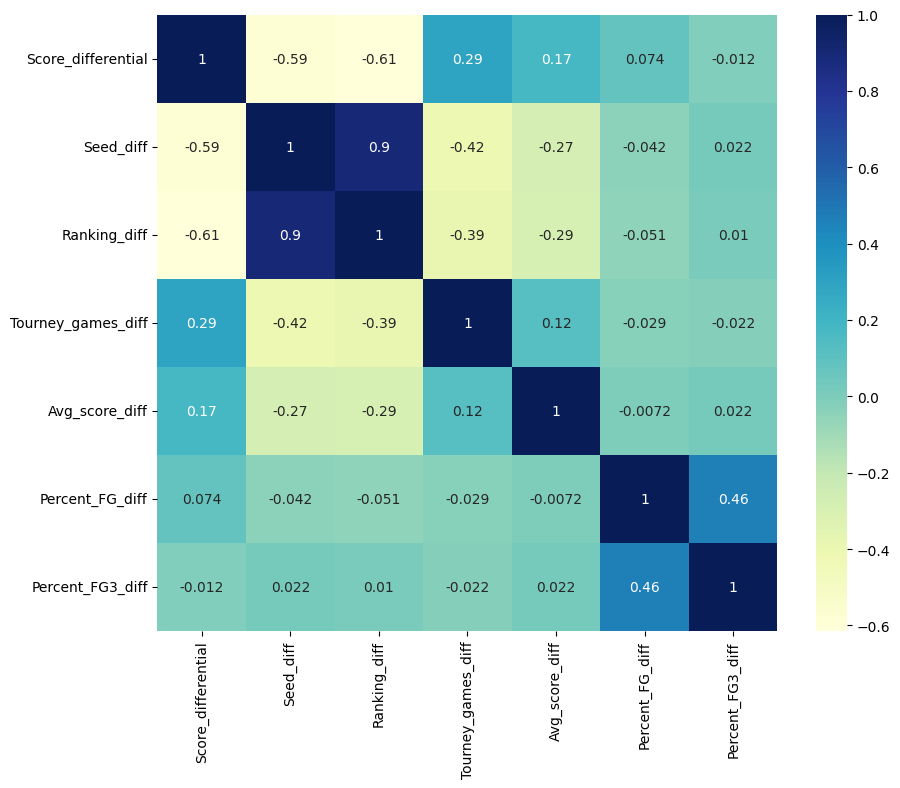

In [43]:
import seaborn as sb
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

feature_df = tourney_games[['Score_differential', 'Seed_diff', 'Ranking_diff', 'Tourney_games_diff', 'Avg_score_diff', 'Percent_FG_diff', 'Percent_FG3_diff']]
sb.heatmap(feature_df.corr(), cmap="YlGnBu", annot=True)


Insights from the coorelation matrix:
- As we anticipated earlier, Seed_diff and Ranking_diff have a negative relationship with Score_differential
- Surprisingly, teams who make a higher percentage of 3 pointers have a slight negative score differential
- Field goal percentage and 3 point percentage are positively correlated as expected
- Seed_diff and Ranking_diff are positively correlated as expected

Finally, we can create our training and testing datasets. I decided to drop Percent_FG3_diff because it was negatively correlated with Score_differential and close enough to Percent_FG_diff that its positive predictive power can be represented through the overal field goal percentage. 

In [44]:
def final_features(games, training=False):
    games.fillna(0, inplace=True)
    games['Team1'] = games['Team1'].astype('category')
    games['Team2'] = games['Team2'].astype('category')
    if training:
        features = ['Team1', 'Team2', 'Seed_diff', 'Ranking_diff', 'Tourney_games_diff', 'Tourney', 'Avg_score_diff', 'Percent_FG_diff', 'Score_differential']
    else:   
        features = ['Team1', 'Team2', 'Seed_diff', 'Ranking_diff', 'Tourney_games_diff', 'Tourney', 'Avg_score_diff', 'Percent_FG_diff']
    games = games[features]
    return games

In [45]:
train = pd.concat([tourney_games, season_games])
train = final_features(train, training=True)

test = test_games
test = final_features(test)
train.tail()

,Team1,Team2,Seed_diff,Ranking_diff,Tourney_games_diff,Tourney,Avg_score_diff,Percent_FG_diff,Score_differential
181677,1104,1401,0.0,-21.0,-2.0,0,-5.062591,0.004948,19
181678,1222,1272,0.0,-27.0,7.0,0,2.148470,-0.023316,-10
181679,1343,1463,0.0,41.0,-2.0,0,-8.083793,-0.062738,9
181680,1336,1345,0.0,46.0,-10.0,0,-11.325286,-0.012206,-2
181681,1173,1433,0.0,18.0,0.0,0,2.714271,-0.017156,-12


To verify the best features to use in the Random Forest Regressor, I use Recursive Feature Elimination with Cross Validation to confirm.

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

def select_features(df):
    all_X = df.drop(['Team1','Team2','Score_differential'], axis=1)
    all_Y = df['Score_differential']
    
    clf = RandomForestRegressor(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_Y)
    
    best_columns = list(all_X.columns[selector.support_])
    print(best_columns)
    return best_columns

In [47]:
from sklearn import preprocessing
cols = select_features(train)

['Seed_diff', 'Ranking_diff', 'Tourney_games_diff', 'Tourney', 'Avg_score_diff', 'Percent_FG_diff']


Now that we have our final features, we can standardize our data using a MinMax Scaler. 

In [48]:
x = train[cols].values #returns a numpy array
y = test[cols].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y_scaled = min_max_scaler.fit_transform(y)
train2 = pd.DataFrame(x_scaled)
test2 = pd.DataFrame(y_scaled)
train2.head()

,0,1,2,3,4,5
0,0.500000,0.503608,0.500000,1.0,0.496552,0.554680
1,0.000000,0.275613,0.833333,1.0,0.496552,0.510769
2,0.600000,0.513709,0.500000,1.0,0.496552,0.570006
3,0.666667,0.533911,0.333333,1.0,0.496552,0.574248
4,0.466667,0.471861,0.527778,1.0,0.496552,0.502533


## 3) Hyperparameter Selection and Model Fitting

I used GridSearchCV to test and fit the best hyperparameters for the Random Forest Regressor:
- n_estimators: uses 100 trees in the forest
- max_features: 2 features used in bootstrapping
- min_samples_leaf: must have at least 10 samples in every leaf node
- min_samples_split: must have at least 32 samples to split a node

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

def select_model(df, df2):
    all_X = df2
    all_Y = df["Score_differential"]
    
    models = [
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(),
            "hyperparameters":
                {
                    "n_estimators": [10,50,100],
                    "max_features": [1,2],
                    "min_samples_leaf": [1,5,10],
                    "min_samples_split": [2,16,32]
                }
        }
#         {
#             "name": "DecisionTreeRegressor",
#             "estimator": DecisionTreeRegressor(),
#             "hyperparameters":
#                 {
#                     "splitter": ['best'],
#                     "max_depth": [8,10],
#                     "max_features": ['auto'],
#                     "min_samples_leaf": [11,12],
#                     "min_samples_split": [4,5]
#                 }
#         }
#         {
#             "name": "KNeighborsRegressor",
#             "estimator": KNeighborsRegressor(),
#             "hyperparameters":
#                 {
#                     "n_neighbors": range(17,26),
#                     "weights": ["distance", "uniform"],
#                     "algorithm": ["auto"],
#                     "p": [1,2]
#                 }
#         }
    ]

    for model in models:
        print(model['name'])
        rmse = make_scorer(mean_squared_error, greater_is_better=False)
        grid = GridSearchCV(model['estimator'],
                           param_grid = model['hyperparameters'],
                           cv=10,
                           scoring = rmse)
        grid.fit(all_X, all_Y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        print('Best Score: {}'.format(model['best_score']))
        print('Best Parameters: {}'.format(model['best_params']))
    return models

In [50]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
result = select_model(train, train2)

RandomForestRegressor
Best Score: -146.8913155654984
Best Parameters: {'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 32, 'n_estimators': 100}


Now we can fit our model with the best hyperparameters and create predictions on our holdout data. 

In [52]:
holdout_data = test2
rfr = RandomForestRegressor(max_features=2, min_samples_leaf=10, min_samples_split=32, n_estimators=100)
rfr.fit(train2, train['Score_differential'])
predictions = rfr.predict(holdout_data)
submission2023 = pd.DataFrame({'Team1': test_games.Team1,
                           'Team2': test_games.Team2,
                           'Season': test_games.Season,
                           'Pred': predictions})

See below for a glimpse at our prediction output:

In [53]:
submission2023.head()

,Team1,Team2,Season,Pred
1089,1104,1112,2023,3.637944
1090,1104,1113,2023,10.453427
1093,1104,1116,2023,1.155992
1096,1104,1120,2023,3.128209
1099,1104,1124,2023,1.571809


In order to interpret results and fill out a bracket, I want to convert Team ID's to Team Names. Therefore, I map the two and replace column entries for TeamID.

In [54]:
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2023
1,1102,Air Force,1985,2023
2,1103,Akron,1985,2023
3,1104,Alabama,1985,2023
4,1105,Alabama A&M,2000,2023


In [55]:
teams = teams.set_index('TeamID')
teams = teams['TeamName'].to_dict()

In [56]:
submission2023['Team1'] = submission2023['Team1'].replace(teams)
submission2023['Team2'] = submission2023['Team2'].replace(teams)
dic = submission2023['Team1'].value_counts().to_dict()

Lastly, we will convert predictions for every potential matchup between Tournament teams into a .csv file for analysis. 

In [57]:
submission2023.to_csv("submission_2023.csv", index=False)